In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Feb9_2017

GluGluHToWW_Pt-200ToInf_M-125 TTToSemiLeptonic
QCD_Pt_1800to2400


# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- applies a specified preselection
- saves the combined dataframe under `events[ch][sample]`

In [3]:
year = "2017"
channels = ["mu", "ele"]

samples_dir = "../Feb9_2017"
samples = os.listdir(samples_dir)

combine_samples = {
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    
    # bkg
    "QCD_Pt": "QCD",
    "TT": "TTbar",
}

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

In [4]:
def apply_selection(preselection):

    events_dict = {}

    for ch in channels:
        print("-------------------------------------------")
        print(f"{ch} channel")
        events_dict[ch] = {}
        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        for sample in samples:

            ### get a combined label to combine samples of the same process
            for key in combine_samples:
                if key in sample:
                    sample_to_use = combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if not parquet_files:
                print(f"No parquet file for {sample}")
                continue                

            data = pd.read_parquet(parquet_files)
            not_empty = len(data) > 0

            # apply selection
            print("---> Applying preselection.")
            for selection in preselection[ch]:
                print(f"applying {selection} selection on {len(data)} events")
                data = data.query(preselection[ch][selection])
            print("---> Done with preselection.")

            # get event_weight
            print("---> Accumulating event weights.")                
            event_weight = utils.get_xsecweight(pkl_files, year, sample, False, luminosity)
            for w in weights[ch]:
                if w not in data.keys():
                    print(f"{w} weight is not stored in parquet")
                    continue
                event_weight *= data[w]
            data["event_weight"] = event_weight
            print("---> Done with accumulating event weights.")                       

            print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
            print(f"tot event weight {data['event_weight'].sum()} \n")

            # fill the big dataframe
            if sample_to_use not in events_dict[ch].keys():
                events_dict[ch][sample_to_use] = data
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])
    return events_dict

In [5]:
events_dict = {}

In [6]:
# always true preselection
no_presel = {
    "mu": {
         "leptonKin": "(lep_pt > 0)",
    },
    "ele": {
         "leptonKin": "(lep_pt > 0)",
    }
}

events_dict["before"] = apply_selection(no_presel)

-------------------------------------------
mu channel
Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying leptonKin selection on 24213 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 21460 events
tot event weight 2367011.4932035427 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying leptonKin selection on 69358 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 63747 events
tot event weight 520.3026967957728 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying leptonKin selection on 106281 ev

In [7]:
presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",        
        
#         # iso/miso experiments        
#         "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",
    }
}

events_dict["after"] = apply_selection(presel)

-------------------------------------------
mu channel
Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying leptonKin selection on 24213 events
applying fatjetKin selection on 21460 events
applying ht selection on 4093 events
applying oneLepton selection on 4093 events
applying notaus selection on 3876 events
applying leptonInJet selection on 2800 events
applying metfilters selection on 874 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 874 events
tot event weight 90298.70862244119 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying leptonKin selection on 69358 events
applying fatjetKin selection on 63747 events
applying ht selection on 51946 events
applying oneLepton selection on 51899 events
applying n

# Regressed mass

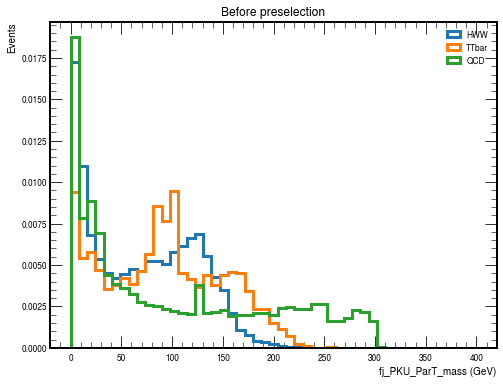

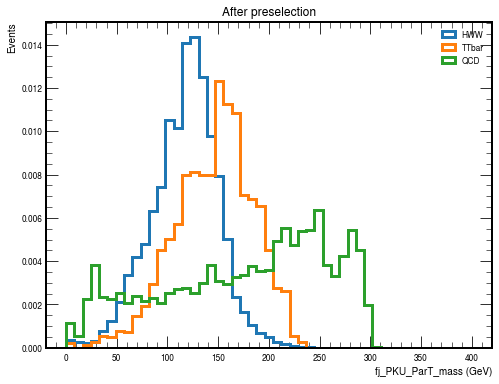

In [8]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

### before preselection
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
for sample in samples_to_plot:
    ax.hist(
        events_dict["before"]["mu"][sample]["fj_PKU_ParT_mass"].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict["before"]["mu"][sample]["event_weight"].values        
    )    
ax.legend()
ax.set_ylabel("Events")
ax.set_xlabel("fj_PKU_ParT_mass (GeV)")
ax.set_title("Before preselection");


### after preselection
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
for sample in samples_to_plot:
    ax.hist(
        events_dict["after"]["mu"][sample]["fj_PKU_ParT_mass"].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict["after"]["mu"][sample]["event_weight"].values
    )    
ax.legend()
ax.set_ylabel("Events")
ax.set_xlabel("fj_PKU_ParT_mass (GeV)")
ax.set_title("After preselection");

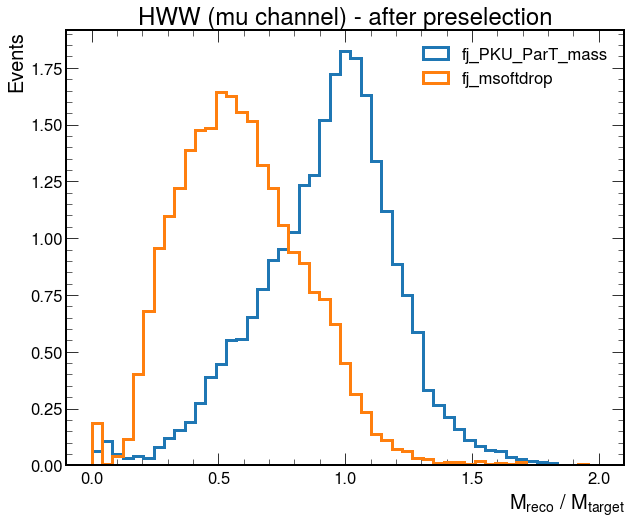

In [9]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)
match_bool = events_dict["after"]["mu"]["HWW"]["fj_H_VV_isMatched"].values
ax.hist(
    events_dict["after"]["mu"]["HWW"]["fj_PKU_ParT_mass"][match_bool].values/125,
    bins_,
    label="fj_PKU_ParT_mass",
    linewidth=3,
    density=True,
    histtype="step"
)   
ax.hist(
    events_dict["after"]["mu"]["HWW"]["fj_msoftdrop"][match_bool].values/125,
    bins_,
    label="fj_msoftdrop",
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend()
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title("HWW (mu channel) - after preselection");

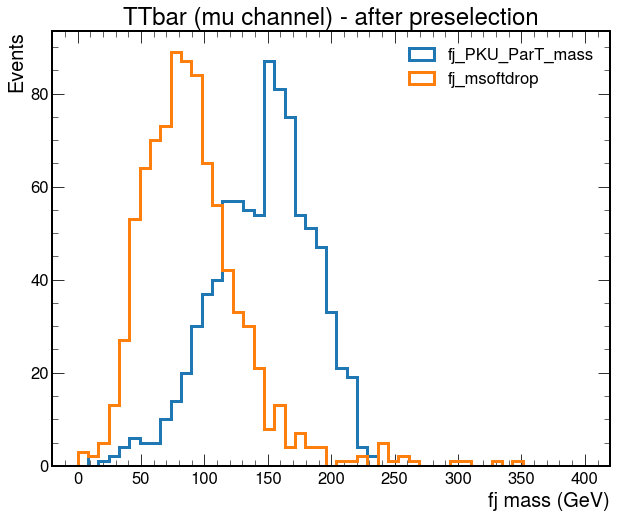

In [10]:
samples_to_plot = ["HWW", "TTbar", "QCD"]

plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,400)
ax.hist(
    events_dict["after"]["mu"]["TTbar"]["fj_PKU_ParT_mass"].values,
    bins_,
    label="fj_PKU_ParT_mass",
    linewidth=3,
#         density=True,
    histtype="step"
)   
ax.hist(
    events_dict["after"]["mu"]["TTbar"]["fj_msoftdrop"].values,
    bins_,
    label="fj_msoftdrop",
    linewidth=3,
#         density=True,
    histtype="step"
)  
ax.legend()
ax.set_ylabel("Events")
ax.set_xlabel("fj mass (GeV)")
ax.set_title("TTbar (mu channel) - after preselection");

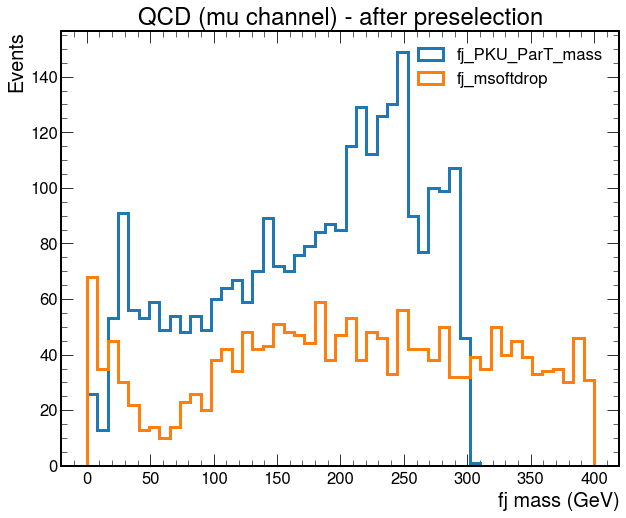

In [11]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,400)
ax.hist(
    events_dict["after"]["mu"]["QCD"]["fj_PKU_ParT_mass"].values,
    bins_,
    label="fj_PKU_ParT_mass",
    linewidth=3,
#         density=True,
    histtype="step"
)   
ax.hist(
    events_dict["after"]["mu"]["QCD"]["fj_msoftdrop"].values,
    bins_,
    label="fj_msoftdrop",
    linewidth=3,
#         density=True,
    histtype="step"
)  
ax.legend()
ax.set_ylabel("Events")
ax.set_xlabel("fj mass (GeV)")
ax.set_title("QCD (mu channel) - after preselection");

## Stacked hists

In [12]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# this is actually no longer by channel since I don't have channels for VH, but leave the name for now, since 2018 is different than other years:w
data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
    "DoubleEG": "DoubleEG",
}
data_by_ch_2018 = {
    "ele": "EGamma",  # i guess there was no single electron for this year, so cristina used eGamma instead of single electron?
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
}

signal_by_ch = {
    "ele": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBFH",
    ],
    "mu": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"
    ],
}

In [13]:
def plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False):
    # data label
    data_label = data_by_ch[ch]
    if year == "2018":
        data_label = data_by_ch_2018[ch]

    # luminosity
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch_][year_]
        luminosity = luminosity / 1000.0

    #     if year_ == "Run2":
    #         data_label = "Data"

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signal_by_ch[ch]]
        bkg_labels = [
            label
            for label in samples
            if (label and label != data_label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        data = None
        if data_label in h.axes[0]:
            data = h[{"samples": data_label}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(1, 1)
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "lep_fj_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
#             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
#             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"{label_by_ch[ch]} Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(10)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [14]:
year_ = "2017"
ch_ = "mu"

### get samples_to_plot
samples_to_plot = ["HWW", "QCD", "TTbar"]

# fill histograms
hists = {}

hists["fj_PKU_ParT_mass"] = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    hist2.axis.Regular(45, 20, 400, name="var", label=r"fj_PKU_ParT_mass [GeV]", overflow=True),
)

hists["fj_pt"] = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
     hist2.axis.Regular(30, 200, 1000, name="var", label=r"Jet $p_T$ [GeV]", overflow=True),
)

for sample in samples_to_plot:
    hists["fj_pt"].fill(
        samples=sample,
        var=events_dict["before"][ch_][sample]["fj_pt"],
        weight=events_dict["before"][ch_][sample]["event_weight"]
    )
    hists["fj_PKU_ParT_mass"].fill(
        samples=sample,
        var=events_dict["before"][ch_][sample]["fj_PKU_ParT_mass"],
        weight=events_dict["before"][ch_][sample]["event_weight"]
    )
    
hists["fj_PKU_ParT_mass"][{"samples": "HWW"}]        

Hist(Regular(45, 20, 400, name='var', label='fj_PKU_ParT_mass [GeV]'), storage=Double()) # Sum: 317.20607763564976 (520.3026967957729 with flow)

Will plot fj_PKU_ParT_mass histogram


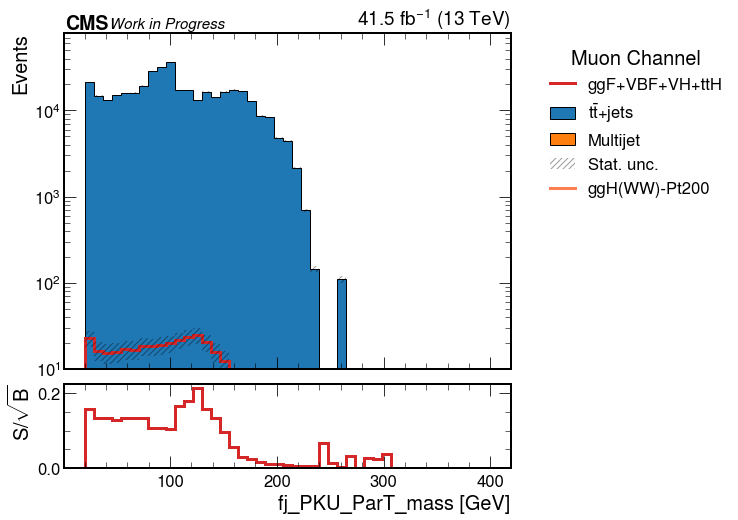

In [15]:
ch = "mu"
vars_to_plot = ["fj_PKU_ParT_mass"]

plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False)